### 1. A/B–тестирование
#### 1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

#### 1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 
1.3 Вопросы

Предлагаем Вам ответить на следующие вопросы:

На какие метрики Вы смотрите в ходе анализа и почему?
Имеются ли различия в показателях и с чем они могут быть связаны?
Являются ли эти различия статистически значимыми?
Стоит ли запускать новую механику на всех пользователей?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from tqdm.auto import tqdm

plt.style.use('ggplot')

In [2]:
groups = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/ptazHvJJLTvlKg', sep=';')

In [3]:
group_add = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/EIB_bq6m4EIA_g', sep=';')

In [4]:
checks = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/XxzRVp8_-NyUcw', sep=';')

In [5]:
active_studs = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/lOeoIDTGrukBbw')

Оценим, что из себя представляют имеющиеся данные и их объём

In [6]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [7]:
groups.shape

(74484, 2)

In [8]:
groups.query('grp == "A"').shape

(14671, 2)

In [9]:
groups.query('grp == "B"').shape

(59813, 2)

In [10]:
group_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [11]:
group_add.shape

(92, 2)

In [12]:
group_add.grp.unique()

array(['B', 'A'], dtype=object)

In [13]:
group_add.query('grp == "A"').shape

(22, 2)

In [14]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [15]:
active_studs.shape

(8341, 1)

Проверим, были ли повторные посещения

In [16]:
active_studs.student_id.nunique()

8341

In [17]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [18]:
checks.shape

(541, 2)

Проверим, были ли повторные покупки

In [19]:
checks.student_id.nunique()

541

Объединим пользователей, разбитых на группы

In [20]:
groups_all = groups.append(group_add)

In [21]:
groups_all.shape

(74576, 2)

In [22]:
groups_all.id.nunique()

74576

Добавим колонку о посещении в датафрейм пользователей, которые зашли во время эксперимента

In [23]:
active_studs['visit'] = 1
active_studs.head()

,student_id,visit
0,581585,1
1,5723133,1
2,3276743,1
3,4238589,1
4,4475369,1


Объединим данные о посещении пользователей с данными о покупках

In [24]:
active_checks = active_studs.merge(checks, how='outer', on='student_id').fillna(0)

In [25]:
active_checks

,student_id,visit,rev
0,581585,1.0,0.0
1,5723133,1.0,0.0
2,3276743,1.0,0.0
3,4238589,1.0,0.0
4,4475369,1.0,0.0
...,...,...,...
8485,5291900,0.0,199.0
8486,5331842,0.0,290.0
8487,5486319,0.0,199.0
8488,5562806,0.0,398.0


Добавим разбивку на группы

In [26]:
df = active_checks.merge(groups_all, how='left', left_on='student_id', right_on='id').drop(columns='id')
df

,student_id,visit,rev,grp
0,581585,1.0,0.0,A
1,5723133,1.0,0.0,A
2,3276743,1.0,0.0,B
3,4238589,1.0,0.0,A
4,4475369,1.0,0.0,B
...,...,...,...,...
8485,5291900,0.0,199.0,B
8486,5331842,0.0,290.0,B
8487,5486319,0.0,199.0,B
8488,5562806,0.0,398.0,B


In [27]:
df.query('visit==0').shape

(149, 4)

Т.к. в данных мы видим пользователей, которые зашли на сайт до эксперимента и совершил покупку, но не видим тех, которые зашли до, но покупку во время эксперимента не совершили, то будем учитывать только тех пользователей, которые зашли на сайт во время эксперимента

In [28]:
df = df.query('visit==1').drop(columns='visit')

Оценим количество наблюдений в группах

In [29]:
df_A = df.query('grp=="A"')
df_A.shape

(1538, 3)

In [30]:
df_B = df.query('grp=="B"')
df_B.shape

(6803, 3)

Рассмотрим такие метрики как конверсия в покупку и средний чек, в качестве основных показателей, отображающих успешность новой механики оплаты

Добавим в датафреймы такую колонку как конверсия

In [32]:
df_A.loc[:,'cnv'] = df_A.rev.apply(lambda c: 1 if c > 0 else 0)

In [33]:
cnv_A = df_A.cnv.value_counts()
cnv_A

0    1460
1      78
Name: cnv, dtype: int64

In [34]:
df_B.loc[:,'cnv'] = df_B.rev.apply(lambda c: 1 if c > 0 else 0)

In [34]:
cnv_B = df_B.cnv.value_counts()
cnv_B

0    6489
1     314
Name: cnv, dtype: int64

Т.к. конверсии являются качественными независимыми переменными и рассматриваемых групп у нас две, то для оценки разницы конверсий будем использовать Хи-квадрат Пирсона. 
При сравнении на калькуляторе для А/В тестирования https://abtestguide.com/calc/ получен следующий результат: "Наблюдаемая разница в коэффициенте конверсии (-8,99% ) недостаточно велика, чтобы объявить значимого победителя. Нет реальной разницы в производительности между A и B, или вам нужно собрать больше данных".

Сравним средние чеки в выборках

In [35]:
df_A.rev.describe()

count    1538.000000
mean       47.347204
std       290.490632
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      3660.000000
Name: rev, dtype: float64

In [36]:
df_B.rev.describe()

count    6803.000000
mean       58.058798
std       313.770201
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      4650.000000
Name: rev, dtype: float64

Т.к. переменные являются количественными, сравним распределения с нормальным

In [37]:
stats.shapiro(df_A.rev)

ShapiroResult(statistic=0.1541670560836792, pvalue=0.0)

Т.к. в первой же группе pvalue=0.0 и мы отклоняем гипотезу о нормальном распределение, а также обе выборки содержат более 1000 наблюдений и при наличии сильного дисбаланса в группах по количеству наблюдений критерий Манна-Уитни теряет свою мощность, поэтому применим бутстрап

In [38]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2)) 
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/2000 [00:00<?, ?it/s]

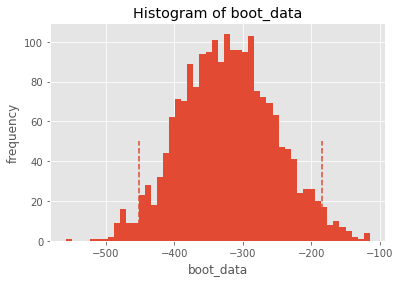

In [39]:
booted_data = get_bootstrap(df_A.query('cnv==1').rev, 
                            df_B.query('cnv==1').rev, boot_it=2000) 
# в результате хранится разница двух распределений, ДИ и pvalue

In [40]:
booted_data["p_value"]

2.673860852359632e-06

In [41]:
booted_data["ci"] 

,0
0.025,-451.627797
0.975,-183.753434


Т.к. в доверительный интервал ноль не попал, а также p_value < 0,05, то принимаем гипотезу о том, что по среднему значению чеки различаются

Сравним медианы чеков в выборках

In [42]:
def get_bootstrap_median(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.median,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2))  # median() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/2000 [00:00<?, ?it/s]

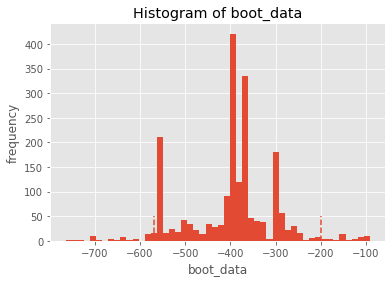

In [43]:
booted_data_median = get_bootstrap_median(df_A.query('cnv==1').rev, df_B.query('cnv==1').rev, boot_it=2000)

In [44]:
booted_data_median["p_value"]

3.261804599014949e-05

In [45]:
booted_data_median["ci"]

,0
0.025,-570.0
0.975,-200.0


Т.к. медианы также значимо отличаются, предполагаем, что на различия средних чеков не повлияли выбросы в данных

## Вывод:
#### Учитывая, что конверсия, как более приоритетная метрика, изменилась незначимо, а средний чек, увеличился, необходимо более детально рассмотреть новый механизм оплаты, мог ли он повлиять только на средний чек. Если нет, то, возможно, произошло пересечение с другим экспериментом, поэтому применять изменения на всех пользователях не стоит

---

### 2 Задача

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

Предположим, у нас есть информация по зарегистрированным студентам (параметр **st_csv**), по покупкам (параметр **checks_csv**) и дополнительный файл по зарегистрированным студентам, который необходимо подгрузить (параметр **st_add_csv**). Также логично было бы предположить, что существует дополнительный файл и по покупкам (параметр - **checks_add_csv**). В **last_m_csv** хранятся ранее рассчитанные метрики

In [46]:
def add_file(st_csv, st_add_csv, checks_csv, checks_add_csv, last_m_csv):
    # считаем все необходимые файлы
    st = pd.read_csv(st_csv, sep=';')
    st_add = pd.read_csv(st_add_csv, sep=';')
    checks = pd.read_csv(checks_csv, sep=';')
    checks_add = pd.read_csv(checks_add_csv, sep=';')
    # добавим новые данные (будем считать, что файлы обновляемые)
    st_all = st.append(st_add)
    checks_all = checks.append(checks_add)
    # рассчитаем конверсию и средний чек
    cnv_ = checks.student_id.nunique() / st_all.id.count()
    avg_check = checks_all.rev.mean()
    date_ = date.today()
    # Запишем получившиеся метрики в новый датасет
    last_m_new = pd.DataFrame({'cnv': [cnv_], 'avg': [avg_check], 'date': [date_]})
    # Если файл с метриками уже был, то обавляем к нему новые данные
    if last_m_csv != '':
        last_m = pd.read_csv(last_m_csv, sep=';', parse_dates=['date'])
        last_m = last_m.append(last_m_new)
        last_m.to_csv(last_m_csv)
    else:
        last_m = last_m_new 
    # записываем метрики в файл
    last_m.to_csv('last_m.csv', sep=';')
    print(f'Вновь рассчитанная конверсия равна: {cnv_}')
    print(f'Вновь рассчитанный средний чек составляет: {avg_check}')

Проверим работу функции на тестовых данных

In [47]:
st_csv = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/ptazHvJJLTvlKg'
checks_csv = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/XxzRVp8_-NyUcw'
st_add_csv = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/EIB_bq6m4EIA_g'
checks_add_csv = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/N_wew7aGuTt03g'
last_m_csv = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/P41EXIq_nbqmFA'

In [48]:
add_file(st_csv, st_add_csv, checks_csv, checks_add_csv, last_m_csv)

Вновь рассчитанная конверсия равна: 0.00725434456125295
Вновь рассчитанный средний чек составляет: 1062.8908207972272


Теперь напишем функци, которая будет строить графики на основании накопленных данных

In [49]:
def new_charts(last_m_csv):
    last_cnv = pd.read_csv(last_m_csv, sep=';', parse_dates=['date']).drop(columns='avg')
    last_avg = pd.read_csv(last_m_csv, sep=';', parse_dates=['date']).drop(columns='cnv')
    plt.figure(figsize=(10, 7))
    sns.lineplot(x='date', y='cnv', data=last_cnv, color='blue')
    plt.show()
    plt.figure(figsize=(10, 7))
    sns.lineplot(x='date', y='avg', data=last_avg, color='orange')
    plt.show()

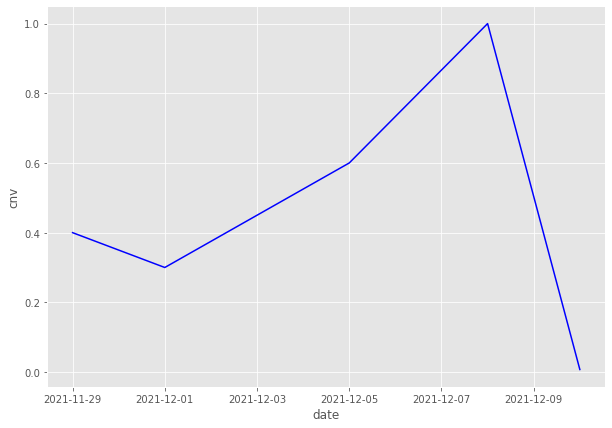

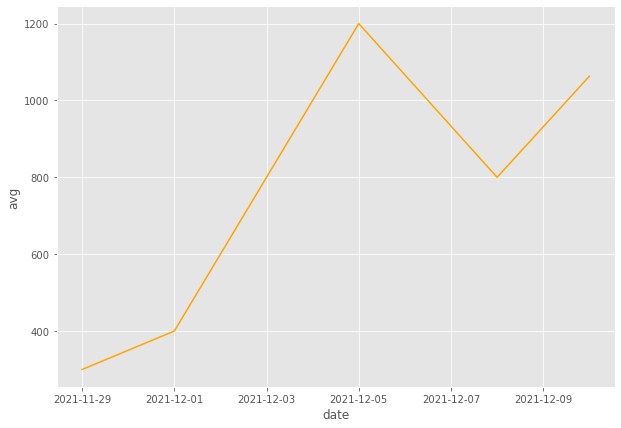

In [50]:
new_charts(last_m_csv)